# Predict $F_{sensible}$ from $T_{soil}$ and $\Theta$

In [3]:
import numpy as np
import xarray as xr

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
ftsz=30
plt.rcParams['xtick.labelsize']=ftsz
plt.rcParams['ytick.labelsize']=ftsz
plt.rcParams['axes.labelsize']=ftsz

Using TensorFlow backend.


## Prepare the data

In [6]:
import os
cpath = os.getcwd() # get current path
fn = '%s/data/SS_demo.nc'%cpath

fid = xr.open_dataset(fn) # solar time 10:59
tslb = fid['TSLB'].data # soil temperature
tt = fid['T0'].data # lowest layer potential temperature
hfx = fid['HFX'].data # sensible heat flux
fid.close()

In [3]:
# read from wrfout*

# wrfout_ini = "/global/cscratch1/sd/chen696/dtemp_data/run-JFs4d01-nadv/wrfout/wrfout_d01_2016-08-30_17_30_00" 

# fid_wrfout_ini = xr.open_dataset(wrfout_ini) # solar time 10:59
# tslb = fid_wrfout_ini['TSLB'][0,0,:,:].data # soil temperature
# tt = fid_wrfout_ini['T'][0,0,:,:].data + 300 # lowest layer potential temperature
# hfx = fid_wrfout_ini['HFX'][0,:,:].data # sensible heat flux
# xlat = fid_wrfout_ini['XLAT'][0,:,0].data
# xlong = fid_wrfout_ini['XLONG'][0,0,:].data
# fid_wrfout_ini.close()

# output_data = xr.Dataset({'TSLB':(['lat','lon'],tslb),'T0':(['lat','lon'],tt),'HFX':(['lat','lon'],hfx)},\
#                         coords={'lat':(['lat'],xlat),'lon':(['lon'],xlong)})
# output_data.to_netcdf(path = '%s/SS_demo.nc'%cpath, mode='w', format='NETCDF4_CLASSIC')

In [7]:
# to reshape 2d variables to 1d while remove boundary grids
def to1d_func(var,nbdy):
    nlat = var.shape[0]
    nlon = var.shape[1]
    var1d = np.reshape(var[nbdy:-nbdy,nbdy:-nbdy],(nlat-2*nbdy)*(nlon-2*nbdy),1)
    return var1d

# to nomalize the variables
def nom_func(var):
    var_nom = (var - np.mean(var)) / np.std(var)
    return var_nom

In [8]:

nbdy = 50 # not using nbdy grids close to boundary

# predictors
predictors = np.stack([to1d_func(tslb,nbdy), to1d_func(tt,nbdy)]).transpose()
n_cols = predictors.shape[1]

# target
target = np.expand_dims(to1d_func(hfx,nbdy),1)


## Define regression model

In [9]:
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(10, activation='selu', input_shape=(n_cols,)))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train the model

In [11]:
#%%time

nrp = 1
mymse = np.zeros(nrp)
for ii in range(nrp):
    
    print('Training %d ...'%ii)

    # split the data into training set and test set randomly
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=30)

    # build the model
    model = regression_model()

    # fit the model
    model.fit(X_train, y_train, epochs=10, verbose=2,validation_split=0.4)

    # prediction from test set
    y_pred = model.predict(X_test)

    # calculate the mean squared error
    mymse[ii] = mean_squared_error(y_test, y_pred)
    

Training 0 ...
Train on 380208 samples, validate on 253472 samples
Epoch 1/10
 - 11s - loss: 3695.9854 - val_loss: 3103.7114
Epoch 2/10
 - 11s - loss: 2512.8101 - val_loss: 2006.5937
Epoch 3/10
 - 11s - loss: 1731.3799 - val_loss: 1617.9383
Epoch 4/10
 - 12s - loss: 1627.8481 - val_loss: 1658.4680
Epoch 5/10
 - 12s - loss: 1617.0420 - val_loss: 1591.3940
Epoch 6/10
 - 13s - loss: 1606.9837 - val_loss: 1615.1701
Epoch 7/10
 - 12s - loss: 1600.4216 - val_loss: 1636.8039
Epoch 8/10
 - 13s - loss: 1599.6963 - val_loss: 1577.7352
Epoch 9/10
 - 13s - loss: 1596.8172 - val_loss: 1588.4766
Epoch 10/10
 - 13s - loss: 1593.6871 - val_loss: 1575.6288


## Plot the results

Text(0.5, 1.0, 'Sensible Heat Flux')

<Figure size 432x288 with 0 Axes>

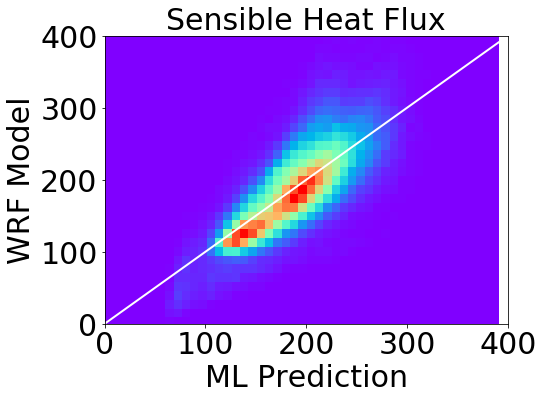

In [12]:
plt.clf()
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8])


ax1.hist2d(y_pred[:,0],y_test[:,0],bins=(50,50),cmap='rainbow')
ax1.plot([0,400],[0,400],linewidth=2,c='w')
ax1.set_xlabel('ML Prediction')
ax1.set_xlim([0,400])

ax1.set_ylabel('WRF Model')
ax1.set_ylim([0,400])

ax1.set_title('Sensible Heat Flux',fontsize=ftsz)

#fig.savefig(savefig_name,dpi=fig.dpi,bbox_inches='tight', pad_inches=0.5)
#plt.close()


For reference below

## Plot MSE 

<Figure size 432x288 with 0 Axes>

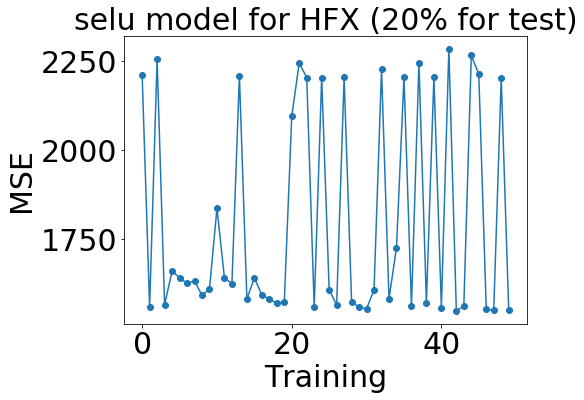

In [ ]:
# plots when test_size=0.2
plt.clf()
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8])

ax1.plot(mymse,'-o')
ax1.set_xlabel('Training')
ax1.set_ylabel('MSE')

ax1.set_title('selu model for HFX (20% for test)',fontsize=ftsz)

fig.savefig("mse_50_epoch10_0p2fortest.png",dpi=fig.dpi,bbox_inches='tight', pad_inches=0.5)
#plt.close()

<Figure size 432x288 with 0 Axes>

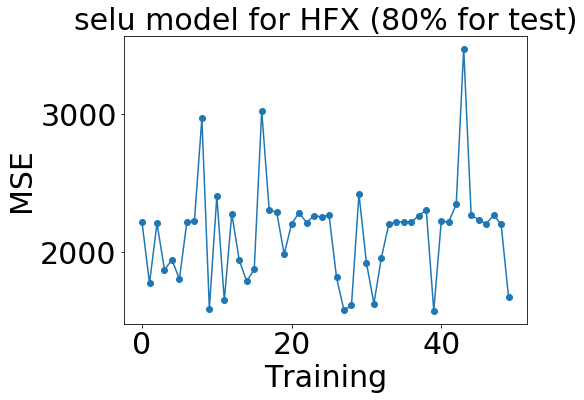

In [22]:
# plots when test_size=0.8
plt.clf()
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8])

ax1.plot(mymse,'-o')
ax1.set_xlabel('Training')
ax1.set_ylabel('MSE')

ax1.set_title('selu model for HFX (80% for test)',fontsize=ftsz)

fig.savefig("mse_50_epoch10_0p8test.png",dpi=fig.dpi,bbox_inches='tight', pad_inches=0.5)
#plt.close()

In [11]:
abc=1